# Fellowship.ai Challenge
> Use a pretrained ResNet 34 and train on the STL10 dataset and then visualize the layer activations using GRADCAM for a mislabeled image of your weakest class. What additional steps would you take to improve the model without changing the number of epochs?

## Summary

From the choice of the dataset and the requirements of the challenge it seems that interpretability and semi-supervised learning are areas of interest in this regard. 

To get familiar with semi-supervised learning and advances in this domain, I found this article very helpful: [Semi-Supervised Learning in Computer Vision](https://amitness.com/2020/07/semi-supervised-learning/). Looking at SOTA techniques in this domain, FixMatch stood out due to its simplicity and superior performance. This [blog](https://amitness.com/2020/03/fixmatch-semi-supervised/) post provides an intuitive detailed explanation of FixMatch. 

**My work can be summarized by:**
- exploring the dataset
- creating a baseline model
- using semi-supervised learning by implementing FixMatch to utilize the unlabeled images
- interpretation using GRADCAM

**My main contribution from this work was creating a FixMatch fastai callback that can be used effortlessly within the framework.**  

FixMatch (CTA) achieved 94.83% on this dataset, while FixMatch (RA) achieved 92.02% using 1000 labels. 


In my implementation, all data for training was used (5000 labels). This achieved **94.31%** accuracy on the test set. Using one of the predefined folds of 1000 labels drops the error rate by about 10%. This relatively poor performance was partly due to the use of resnet34. Note that no hyperparameters tuning was performed to report these results. The recommended hyperparameters from the [paper](https://arxiv.org/abs/2001.07685) was used. 

This implementation was based on FixMatch pytorch implementation from this [repo](https://github.com/kekmodel/FixMatch-pytorch), and utilizing RandAugment from `timm` library. 

Visualization of the final layer activations using GRADCAM for a mislabeled image of the weakest class was done using fastai hook callback. 

**Final remarks:**

- Some of the unlabeled images from this dataset come from a similar but different distribution from the labeled data which makes it a more realistic challenge.
- resnet34 model is not a good choice for interpretability purposes and performance wise. As images size is relatively small (96x96), the size of feature map at the last conv layer of the model is very small (only 3x3). This is not good enough for a detailed interpretability. Additionally, deeper networks are not likely to improve performance.
- A shallower and wider network would do better in this scenario. This is justified by the observations made below and by the model of choice when reporting SOTA resutls in published papers which is a wide resnet network(WRN-37-2).
- Great amount of debugging went into this work to make it happen. Tests for GPU memory leak was also performed to insure smooth training on long runs. 
- Additional work can be done to explore the utilization of the unlabeled images like, monitoring percentage of used images for pseudo labeling, visually analyzing a sample of utilized images, and the possibility of removing out of domain images to enhance the quality and speed of training. 

## Introduction

>Overview of the dataset: 
>- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
>- Images are 96x96 pixels, color.
>- 500 training images, 800 test images per class.
>- 100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
>- Images were acquired from labeled examples on ImageNet.

This is a standardized and a relatively clean dataset. All images have the same size, and training and test images are predefined. This makes it easier to quickly start with experiments as there is not much preprocessing required. A quick sanity check to verify above info seems like enough to start with. 

In [143]:
from fastai.vision.all import *
from fastai.callback.all import *
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stl10labeled2/test_X.bin
/kaggle/input/stl10labeled2/class_names.txt
/kaggle/input/stl10labeled2/train_X.bin
/kaggle/input/stl10labeled2/test_y.bin
/kaggle/input/stl10labeled2/fold_indices.txt
/kaggle/input/stl10labeled2/train_y.bin


In [164]:
def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [165]:
# labels
l = L(["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"])

In [166]:
# dict of labels for mapping
d = {i+1:v for i,v in enumerate(l)};d

{1: 'airplane',
 2: 'bird',
 3: 'car',
 4: 'cat',
 5: 'deer',
 6: 'dog',
 7: 'horse',
 8: 'monkey',
 9: 'ship',
 10: 'truck'}

In [167]:
tr_imgs = read_all_images("/kaggle/input/stl10labeled2/train_X.bin")
tr_imgs.shape

(5000, 96, 96, 3)

In [175]:
tst_imgs = read_all_images("/kaggle/input/stl10labeled2/test_X.bin")
tst_imgs.shape

(8000, 96, 96, 3)

In [168]:
tr_lbls = read_labels("/kaggle/input/stl10labeled2/train_y.bin")
tr_lbls.shape

(5000,)

In [181]:
tst_lbls = read_labels("/kaggle/input/stl10labeled2/test_y.bin")
tst_lbls.shape

(8000,)

In [182]:
imgs = np.concatenate((tr_imgs,tst_imgs))
lbls = np.concatenate((tr_lbls,tst_lbls))
imgs.shape, lbls.shape

((13000, 96, 96, 3), (13000,))

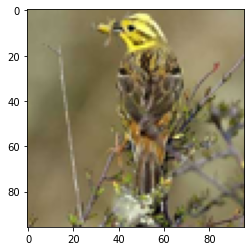

In [183]:
plt.imshow(imgs[0]);

In [231]:
# fastai DataBlock
def get_x(i): return imgs[i]
def get_y(i): return d[lbls[i]]
def get_items(): return L(range(len(imgs)))
db = DataBlock((ImageBlock, CategoryBlock),
               get_x=get_x,
               get_y=get_y,
               splitter=IndexSplitter(L(range(len(tr_imgs),len(imgs)))))

In [15]:
# dataloaders (training and validation)
dls = db.dataloaders(L(range(len(imgs))), bs=128)

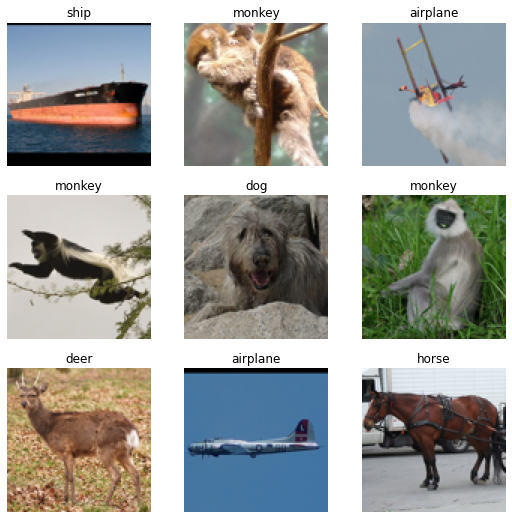

In [233]:
dls.show_batch()

In [234]:
len(dls.train_ds), len(dls.valid_ds)

(5000, 8000)

All looks good so far.

## Baseline

In this section I create a strong baseline using fastai. Various techniques were explored including label smoothing, mixup, cutmix, etc.  
Default data augmentations with label smoothing loss showed the best accuracy of **93.37%** on the validation set. Using mixup resulted in similar performance, while using cutmix performed poorly. Below is a sample run:

In [176]:
# fastai learner
learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy)

In [171]:
# Default data augmentations, bs 128, wd, label smoothing
learn.fine_tune(epochs=50, 
                base_lr=2e-3,
                freeze_epochs=2,
                wd=.05,
                cbs = [SaveModelCallback('accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,2.482444,1.227471,0.773125,00:12
1,1.761858,1.115910,0.813875,00:13


Better model found at epoch 0 with accuracy value: 0.7731249928474426.
Better model found at epoch 1 with accuracy value: 0.8138750195503235.


epoch,train_loss,valid_loss,accuracy,time
0,1.250270,1.031535,0.848125,00:12
1,1.156066,0.957496,0.868375,00:13
2,1.078424,0.911120,0.881500,00:12
3,1.011977,0.877571,0.890125,00:13
4,0.949782,0.841509,0.892875,00:13
5,0.891777,0.821431,0.898375,00:12
6,0.846437,0.799525,0.906125,00:13
7,0.801087,0.782508,0.908125,00:12
8,0.760910,0.762755,0.910750,00:13
9,0.723334,0.740704,0.913250,00:13


Better model found at epoch 0 with accuracy value: 0.8481249809265137.
Better model found at epoch 1 with accuracy value: 0.8683750033378601.
Better model found at epoch 2 with accuracy value: 0.8815000057220459.
Better model found at epoch 3 with accuracy value: 0.8901249766349792.
Better model found at epoch 4 with accuracy value: 0.8928750157356262.
Better model found at epoch 5 with accuracy value: 0.8983749747276306.
Better model found at epoch 6 with accuracy value: 0.906125009059906.
Better model found at epoch 7 with accuracy value: 0.9081249833106995.
Better model found at epoch 8 with accuracy value: 0.9107499718666077.
Better model found at epoch 9 with accuracy value: 0.9132500290870667.
Better model found at epoch 10 with accuracy value: 0.9136250019073486.
Better model found at epoch 11 with accuracy value: 0.9153749942779541.
Better model found at epoch 12 with accuracy value: 0.9210000038146973.
Better model found at epoch 18 with accuracy value: 0.9211249947547913.
Bet

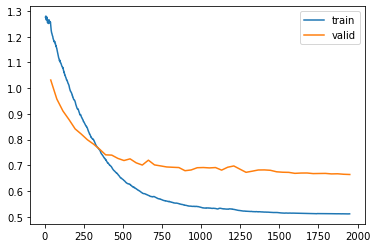

In [172]:
learn.recorder.plot_loss()

A decent accuracy of 93% was achieved with no sign of overfitting.

## FixMatch for Semi-Supervised Learning

In this section, FixMatch is implemented as a fastai callback based on the pure pytorch implementation from this [repo](https://github.com/kekmodel/FixMatch-pytorch). `RandAugment` from `timm` library along with `torchvision` transforms were utilized for the wear and strong augmentations of FixMatch.

![fixmatch%20pipeline.png](attachment:fixmatch%20pipeline.png "hiiii")
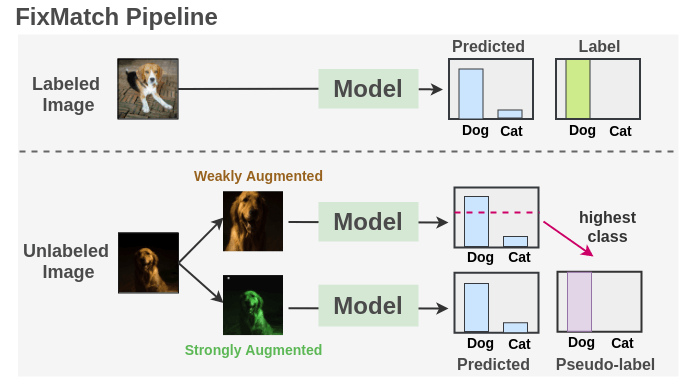

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
from timm.data.auto_augment import rand_augment_transform
# RandAugment for the strong augmentatoins of FixMatch
rand_aug = rand_augment_transform(
    config_str='rand-m9-mstd0.5', 
    hparams={})

In [6]:
stl10_mean = (0.4914, 0.4822, 0.4465)
stl10_std = (0.2471, 0.2435, 0.2616)

In [7]:
# weak and strong transforms used for creating the unlabeled dataset 
class TransformFixMatch(object):
    def __init__(self, mean=stl10_mean, std=stl10_std):
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip()])
        self.strong = rand_aug
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

In [10]:
unlabeled_dataset = torchvision.datasets.STL10(root='/kaggle/input/stl10/', 
                                               split='unlabeled', transform=TransformFixMatch())

In [16]:
# mu is a parameter from FixMatch paper indicating number of unlabeled images within a batch (mu * batch_size)
mu = 7 
batch_size = 64

In [ ]:
dls = db.dataloaders(L(range(len(imgs))), bs=batch_size)

In [18]:
unlabeled_trainloader = torch.utils.data.DataLoader(
        unlabeled_dataset,
        batch_size=batch_size*mu,
        shuffle=True,
        drop_last=True)

In [21]:
# FixMatch Callback
class FixMatch(Callback):
    
    run_valid = False
    
    def __init__(self, unlabeled_trainloader, threshold=.95, lambda_u=1.):
        self.unlabeled_trainloader = unlabeled_trainloader
        self.unlabeled_iter = iter(self.unlabeled_trainloader)
        self.threshold = threshold
        self.lambda_u = lambda_u
        
    def before_train(self):
        self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf
    
    def after_train(self):
        self.learn.loss_func = self.old_lf
        
    def before_batch(self):
        try:
            (self.inputs_u_w, self.inputs_u_s), _ = self.unlabeled_iter.next()
        except:
            self.unlabeled_iter = iter(self.unlabeled_trainloader)
            (self.inputs_u_w, self.inputs_u_s), _ = self.unlabeled_iter.next()
        self.inputs_u_w, self.inputs_u_s = to_device(self.inputs_u_w),to_device(self.inputs_u_s)
        self.learn.xb = tuple(L(torch.cat((self.learn.xb[0], self.inputs_u_w, self.inputs_u_s))))
        
    def after_pred(self):
        self.logits_x = self.pred[:self.dls.train.bs]
        self.logits_u_w, self.logits_u_s = self.pred[self.dls.train.bs:].chunk(2)
        
    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        Lx = self.old_lf(self.logits_x, *yb)                            # loss of labeled images
        pseudo_label = torch.softmax(self.logits_u_w.detach(), dim=-1)  # softmax of weakly aug. images
        max_probs, targets_u = torch.max(pseudo_label, dim=-1)          # probability and target associated with pseudo labels
        mask = max_probs.ge(self.threshold).float()                     # select pseudo labels above threshold
        with NoneReduce(self.old_lf) as lf:
            uloss = lf(self.logits_u_s, targets_u) * mask               # compute loss on selected pseudo labels
        Lu = reduce_loss(uloss, 'mean')
        return Lx + self.lambda_u * Lu                                  # return combined loss (labeled+unlabeled)
    
    # This is used to monitor GPU memory leak and used only for development 
    def after_epoch(self):
        print("GPU Mem. use = %.2f" %(torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated()) )

This callback runs only during training. 

`before_train` and `after_train` events are used to change the loss function. 

In `before_batch`, we obtain a batch of unlabeled images and append those weakly and strongly augmented images to the current batch of labeled images. 

In `after_pred`, we obtain the logits for all these images (namely, labeled, weakly augments, and strongly augmented images). 

`lf` defines the loss function which consist of our original cross entropy loss on the labeled images and cross entropy loss of the strongly augmented images with pseudo labels that are obtained from the weakly augmented images. 

`after_epoch` is used during development to detect any GPU memory leak. 

In [32]:
model = create_cnn_model(resnet34, n_out=10, pretrained=True, n_in=3)
learn = Learner(dls, model, metrics=accuracy, 
                loss_func=CrossEntropyLossFlat(), opt_func=SGD, wd=.005, 
                cbs=[SaveModelCallback('accuracy'), FixMatch(unlabeled_trainloader)])

In [24]:
 torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() 

0.00019954674382474094

In [25]:
learn.fit_one_cycle(70, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.725328,1.479299,0.504250,01:51
1,1.948466,0.839788,0.726625,01:48
2,1.349762,0.521621,0.825875,01:49
3,0.994562,0.399612,0.867625,01:49
4,0.740994,0.347668,0.889750,01:48
5,0.598104,0.299746,0.904125,01:49
6,0.515231,0.305839,0.909375,01:50
7,0.455256,0.347229,0.902875,01:48
8,0.409240,0.334249,0.910375,01:49
9,0.380092,0.324246,0.909625,01:49


GPU Mem. use = 0.03
Better model found at epoch 0 with accuracy value: 0.5042499899864197.
GPU Mem. use = 0.03
Better model found at epoch 1 with accuracy value: 0.7266250252723694.
GPU Mem. use = 0.03
Better model found at epoch 2 with accuracy value: 0.8258749842643738.
GPU Mem. use = 0.03
Better model found at epoch 3 with accuracy value: 0.8676249980926514.
GPU Mem. use = 0.03
Better model found at epoch 4 with accuracy value: 0.8897500038146973.
GPU Mem. use = 0.03
Better model found at epoch 5 with accuracy value: 0.9041249752044678.
GPU Mem. use = 0.03
Better model found at epoch 6 with accuracy value: 0.909375011920929.
GPU Mem. use = 0.03
GPU Mem. use = 0.03
Better model found at epoch 8 with accuracy value: 0.9103749990463257.
GPU Mem. use = 0.03
GPU Mem. use = 0.03
Better model found at epoch 10 with accuracy value: 0.9167500138282776.
GPU Mem. use = 0.03
GPU Mem. use = 0.03
GPU Mem. use = 0.03
GPU Mem. use = 0.03
Better model found at epoch 14 with accuracy value: 0.9168750

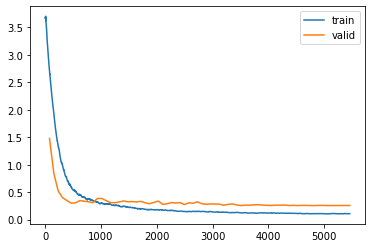

In [26]:
learn.recorder.plot_loss()

A better accuracy of **94.31%** is achieved by utilizing the unlabeled images which translates to about **1%** reduction in error rate. 

## Results and Interpretation using GRADCAM

Results are investigated using fastai handy tools. This including confusion matrix, classification report, weakest classes, and images that resulted in the worse losses. 

GRADCAM is used to visualize the activations of the last conv layer (before the classifier) of a mislabeled image involving the weakest class (`cat` in this case). In this technique the gradients at the feature map layer with respect to the output of a particular class are used as weights to visualize the feature map. This is done by taking the dot product of weights and feature map to produce CAM. 

The last feature map was relatively small (only 3x3), hence we expect CAM to not be as detailed. 

To overcome this issue, I tried to double the size of the input image to (192x192). This resulted in a feature map of size (6x6). Surprise, surprise!! the model predicted the right label this time :)

Comparing the feature maps, we can see in the small image case the model was focusing mostly on the center of the image. However, the feature map of the large image shows that the model had considered other parts of the cat and therefore correctly identified the object. 

Since this model was pretrained on ImageNet with larger images, weight are tuned to detect features at a certain minimum scale. This can be confirmed by having the correct prediction when enlarging the image in some cases. Another approach to consider for improving the model's performance is to train from scratch rather starting from a pertrained model that doesn't nicely fit the task. 

For this reason, I believe that a wider and shallower network is more suitable for this task.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

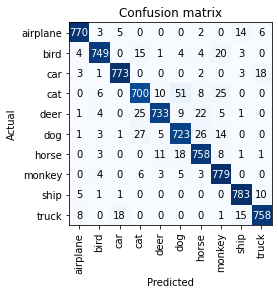

In [40]:
interp.plot_confusion_matrix()

`cat` is the weakest class with 100 misclassifactions. Cats were mostly confused by dogs and monkeys. 

In [42]:
interp.print_classification_report()

              precision    recall  f1-score   support

    airplane       0.97      0.96      0.97       800
        bird       0.97      0.94      0.95       800
         car       0.97      0.97      0.97       800
         cat       0.91      0.88      0.89       800
        deer       0.96      0.92      0.94       800
         dog       0.89      0.90      0.90       800
       horse       0.92      0.95      0.93       800
      monkey       0.91      0.97      0.94       800
        ship       0.95      0.98      0.97       800
       truck       0.96      0.95      0.95       800

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000



In [43]:
# most confused classes
interp.most_confused(25)

[('cat', 'dog', 51),
 ('dog', 'cat', 27),
 ('dog', 'horse', 26),
 ('cat', 'monkey', 25),
 ('deer', 'cat', 25)]

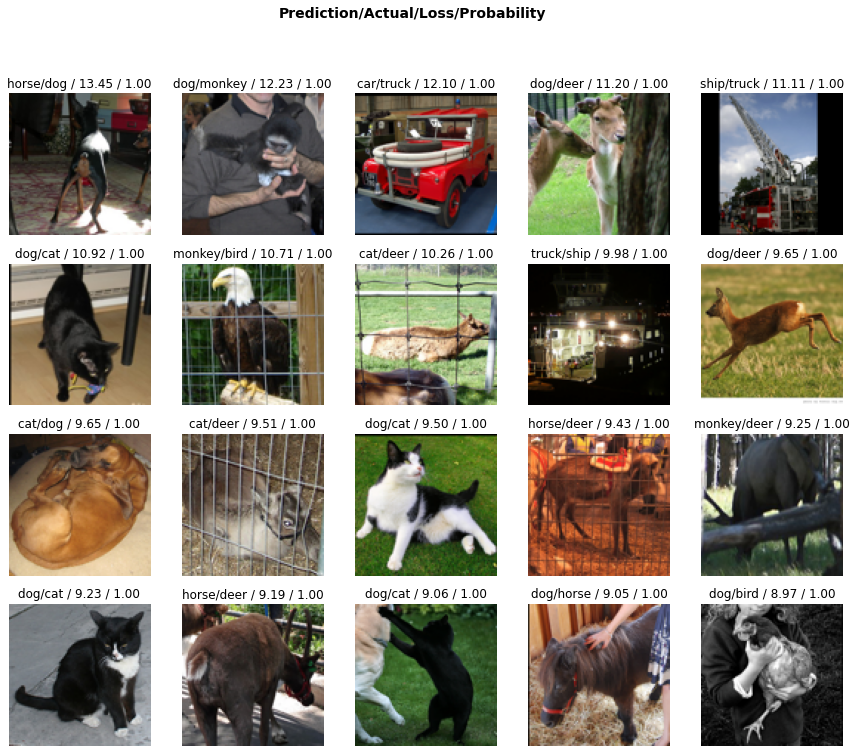

In [44]:
# images that resulted the highest losses
interp.plot_top_losses(20)

In [45]:
interp.top_losses()

(TensorBase([13.4465, 12.2293, 12.0993,  ..., -0.0000, -0.0000, -0.0000]),
 TensorBase([1525, 3975,  417,  ...,  719, 1178, 2675]))

Choose an image of a cat from above images (images that resulted the highest losses)

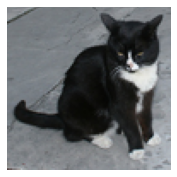

In [196]:
import PIL
img = PILImage.create(imgs[5000+interp.top_losses()[1][15].item()])
show_image(img);

In [137]:
# create a test dataloader with this image
x, = first(dls.test_dl([img]))
# model[0] gives the first part of the model before the classifier
with torch.no_grad(): output = learn.model[0].eval()(x)
print(output.shape)

(1, 512, 3, 3)


notice that the size of the feature map is very small (3x3).

In [203]:
# confirm the classification
index_to_label[output.argmax().item()+1]

'dog'

In [232]:
# use a forward hook to capture the activations and 
# a backward hook to capture the grads of the last conv layer
# with respect to the output at our class on intereset
cls = 3 #cat
with Hook(learn.model[0], lambda m,gi,go:go) as bh:
    with Hook(learn.model[0], lambda m,i,o:o) as fh:
        output = learn.model.eval()(x)
        act = fh.stored
    output[:,cls].backward()
    grad = bh.stored

In [233]:
act.shape, output.shape, grad.shape

((1, 512, 3, 3), torch.Size([1, 10]), (1, 512, 3, 3))

In [145]:
# take the mean of grads for each channel and use it as a weight
w = grad.squeeze().mean(dim=[1,2], keepdim=True)
w.shape

(512, 1, 1)

In [147]:
# create cam by perforing a dot product and taking the mean across channels 
cam_map = (w * act.squeeze()).mean(0)
cam_map.shape

(3, 3)

In [150]:
# normalize the map between 0 and 1
cam_map = (cam_map-cam_map.min())
cam_map /= cam_map.max()
cam_map.min(), cam_map.max()

(TensorImage(0.), TensorImage(1.))

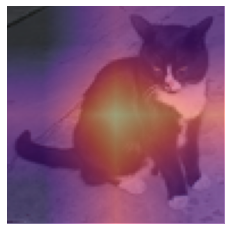

In [240]:
_,ax = plt.subplots()
show_image(img, ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,96,96,0),
              interpolation='bilinear', cmap='magma');

Focus is mainly at the center of the image. The model is somehow ignoring other important parts of the cat like its face and legs. 

As mentioned earlier, the feature map is very small. To get a more detailed feature map, I'll double the size of the input image. 

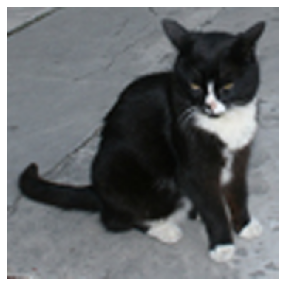

In [241]:
img = PILImage(img.resize((192,192), PIL.Image.BICUBIC))
show_image(img);

In [242]:
x, = first(dls.test_dl([img]))
with torch.no_grad(): output = learn.model.eval()(x)
index_to_label[output.argmax().item()+1]

'cat'

The model recognizes the correct object after enlarging the model! 

Let's explore the feature map. 

In [256]:
cls = 3
with Hook(learn.model[0], lambda m,gi,go:go) as bh:
    with Hook(learn.model[0], lambda m,i,o:o) as fh:
        output = learn.model(x)
        act = fh.stored
    output[:,cls].backward()
    grad = bh.stored

In [ ]:
w = grad.squeeze().mean(dim=[1,2], keepdim=True)
cam_map = (w * act.squeeze()).mean(0)
cam_map = (cam_map-cam_map.min())
cam_map /= cam_map.max()

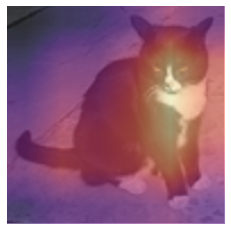

In [259]:
_,ax = plt.subplots()
show_image(img, ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,192,192,0),
              interpolation='bilinear', cmap='magma');

In [98]:
act.shape

(1, 512, 6, 6)

Now, the model focuses on the entire object and predicts the correct label.

Let's repeat the same process for another image which have both a cat and a dog form the above images. 

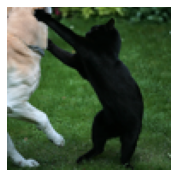

In [261]:
img = PILImage.create(imgs[5000+interp.top_losses()[1][17].item()])
show_image(img);

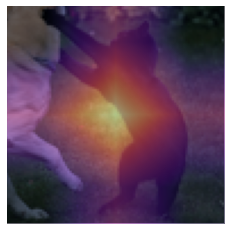

In [278]:
# input image with original size
_,ax = plt.subplots()
show_image(img, ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,96,96,0),
              interpolation='bilinear', cmap='magma');

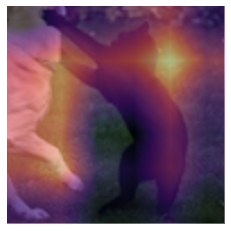

In [299]:
# input image with double the size of the original
_,ax = plt.subplots()
show_image(img, ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,192,192,0),
              interpolation='bilinear', cmap='magma');

Again with the small image, the focus was on the center and prediction was "dog" with no clear indication on why. However, with a larger image size and hence a richer feature map, we can see that the model focuses on the dog and therefore the prediction makes sense. 